<a href="https://colab.research.google.com/github/Nahmadid/WeeklyReport/blob/main/frac_Shupeng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Caputo fpinn**

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys
#tf.disable_v1_behavior()
#tf.enable_eager_execution()
import numpy as np
import time
import random
#from plotting import newfig, savefig
#import matplotlib.gridspec as gridspec
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
np.random.seed(1234)
#tf.set_random_seed(1234)
#N=100, K=10
np.set_printoptions(threshold=np.inf)
'''
Two compartmental fractional derivative model with time Caputo fractional derivative
'''

Instructions for updating:
non-resource variables are not supported in the long term


'\nTwo compartmental fractional derivative model with time Caputo fractional derivative\n'

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

self.loss: Tensor("add_124:0", shape=(), dtype=float32) <class 'tensorflow.python.framework.ops.SymbolicTensor'>
self.train_op_Adam: <class 'tensorflow.python.framework.ops.Operation'>
init ok
begin trainning...
Iter: 0, Loss: 15888.80762, L2: 1.94821, alpha: 1.00010, coef_k: 29.99990, Time: 5.05
Iter: 10, Loss: 2885.86987, L2: 1.93904, alpha: 1.00005, coef_k: 29.99980, Time: 0.14
Iter: 20, Loss: 232.57114, L2: 1.93552, alpha: 0.99999, coef_k: 29.99969, Time: 0.14
Iter: 30, Loss: 62.16291, L2: 1.93556, alpha: 1.00000, coef_k: 29.99948, Time: 0.13
Iter: 40, Loss: 51.29322, L2: 1.93651, alpha: 1.00000, coef_k: 29.99928, Time: 0.13
Iter: 50, Loss: 57.26035, L2: 1.93709, alpha: 1.00000, coef_k: 29.99907, Time: 0.13
Iter: 60, Loss: 52.11340, L2: 1.93739, alpha: 1.00000, coef_k: 29.99886, Time: 0.13
Iter: 70, Loss: 52.07084, L2: 1.93732, alpha: 1.00000

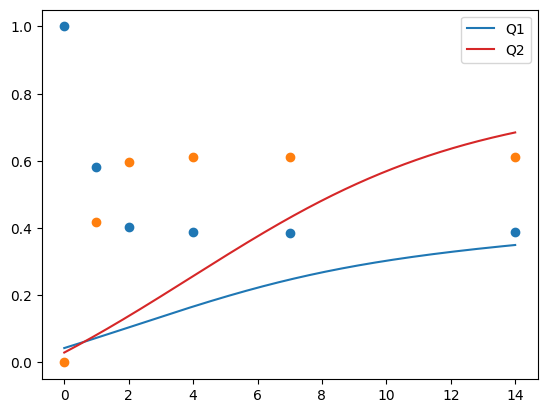

In [ ]:


class FPhysicsInformedNN:
    #initialize the class
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights)

        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-1):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(tf.cast(H, tf.float32), W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def yn(self, a, n, N):
        '''
        a -fractional order
        n -left bound of a
        N -number of coefficients
        '''
        bc=np.zeros(N)
        g=np.zeros(N-1)
        bc[0]=1
        for j in range(1, N):
            bc[j]=bc[j-1]*(1-(a-n+1)/(j))
            g[j-1]=-bc[j]
        F=np.cumsum(g)
        #np.random.seed(42)
        X=np.random.rand(1,N)
        X.sort()
        #print(X)
        edges1=np.insert(F,0,0)
        edges=np.append(edges1,[1])
        #print(edges)
        Y=np.array(np.digitize(X,edges))
        return Y


    def net_Uequ(self, t):
        '''
        set boundary condition: q1(0) = 1, q2(0) = 0
        '''
        #alpha = 0.9997
        N = 12
        dt = t/N
        coef_k = self.coef_k
        alpha = self.alpha

        #coef_k = 0.02
        V1 = 254.5
        V2 = 1000

        Q0 = self.neural_net(tf.concat([0*dt], 1), self.weights, self.biases)
        Q1 = self.neural_net(tf.concat([1*dt], 1), self.weights, self.biases)
        Q2 = self.neural_net(tf.concat([2*dt], 1), self.weights, self.biases)
        Q3 = self.neural_net(tf.concat([3*dt], 1), self.weights, self.biases)
        Q4 = self.neural_net(tf.concat([4*dt], 1), self.weights, self.biases)
        Q5 = self.neural_net(tf.concat([5*dt], 1), self.weights, self.biases)
        Q6 = self.neural_net(tf.concat([6*dt], 1), self.weights, self.biases)
        Q7 = self.neural_net(tf.concat([7*dt], 1), self.weights, self.biases)
        Q8 = self.neural_net(tf.concat([8*dt], 1), self.weights, self.biases)
        Q9 = self.neural_net(tf.concat([9*dt], 1), self.weights, self.biases)
        Q10 = self.neural_net(tf.concat([10*dt], 1), self.weights, self.biases)
        Q11 = self.neural_net(tf.concat([11*dt], 1), self.weights, self.biases)
        Q12 = self.neural_net(tf.concat([12*dt], 1), self.weights, self.biases)

        q1_0 = Q0[:,0:1]
        q2_0 = Q0[:,1:2]

        q1_1 = Q1[:,0:1]
        q2_1 = Q1[:,1:2]

        q1_2 = Q2[:,0:1]
        q2_2 = Q2[:,1:2]

        q1_3 = Q3[:,0:1]
        q2_3 = Q3[:,1:2]

        q1_4 = Q4[:,0:1]
        q2_4 = Q4[:,1:2]

        q1_5 = Q5[:,0:1]
        q2_5 = Q5[:,1:2]

        q1_6 = Q6[:,0:1]
        q2_6 = Q6[:,1:2]

        q1_7 = Q7[:,0:1]
        q2_7 = Q7[:,1:2]

        q1_8 = Q8[:,0:1]
        q2_8 = Q8[:,1:2]

        q1_9 = Q9[:,0:1]
        q2_9 = Q9[:,1:2]

        q1_10 = Q10[:,0:1]
        q2_10 = Q10[:,1:2]

        q1_11 = Q11[:,0:1]
        q2_11 = Q11[:,1:2]

        q1_12 = Q12[:,0:1]
        q2_12 = Q12[:,1:2]

        w_1_0 = tf.pow(1.5, alpha)
        w_1_1 = -2*alpha*tf.pow(2/3, 1 - alpha)
        w_1_2 = ((4*2 - 4 - 4*alpha)*w_1_1)/(3*2) + ((2*alpha)*w_1_0)/(3*2)
        w_1_3 = ((4*3 - 4 - 4*alpha)*w_1_2)/(3*3) + ((2 - 3 + 2*alpha)*w_1_1)/(3*3)
        w_1_4 = ((4*4 - 4 - 4*alpha)*w_1_3)/(3*4) + ((2 - 4 + 2*alpha)*w_1_2)/(3*4)
        w_1_5 = ((4*5 - 4 - 4*alpha)*w_1_4)/(3*5) + ((2 - 5 + 2*alpha)*w_1_3)/(3*5)
        w_1_6 = ((4*6 - 4 - 4*alpha)*w_1_5)/(3*6) + ((2 - 6 + 2*alpha)*w_1_4)/(3*6)
        w_1_7 = ((4*7 - 4 - 4*alpha)*w_1_6)/(3*7) + ((2 - 7 + 2*alpha)*w_1_5)/(3*7)
        w_1_8 = ((4*8 - 4 - 4*alpha)*w_1_7)/(3*8) + ((2 - 8 + 2*alpha)*w_1_6)/(3*8)
        w_1_9 = ((4*9 - 4 - 4*alpha)*w_1_8)/(3*9) + ((2 - 9 + 2*alpha)*w_1_7)/(3*9)
        w_1_10 = ((4*10 - 4 - 4*alpha)*w_1_9)/(3*10) + ((2 - 10 + 2*alpha)*w_1_8)/(3*10)
        w_1_11 = ((4*11 - 4 - 4*alpha)*w_1_10)/(3*11) + ((2 - 11 + 2*alpha)*w_1_9)/(3*11)
        w_1_12 = ((4*12 - 4 - 4*alpha)*w_1_11)/(3*12) + ((2 - 12 + 2*alpha)*w_1_10)/(3*12)


        Dt1 = (1/(tf.pow(dt,alpha)))*w_1_12*q1_0 + \
            (1/(tf.pow(dt,alpha)))*w_1_11*q1_1 + \
            (1/(tf.pow(dt,alpha)))*w_1_10*q1_2 + \
            (1/(tf.pow(dt,alpha)))*w_1_9*q1_3 + \
            (1/(tf.pow(dt,alpha)))*w_1_8*q1_4 + \
            (1/(tf.pow(dt,alpha)))*w_1_7*q1_5 + \
            (1/(tf.pow(dt,alpha)))*w_1_6*q1_6 + \
            (1/(tf.pow(dt,alpha)))*w_1_5*q1_7 + \
            (1/(tf.pow(dt,alpha)))*w_1_4*q1_8 + \
            (1/(tf.pow(dt,alpha)))*w_1_3*q1_9 + \
            (1/(tf.pow(dt,alpha)))*w_1_2*q1_10 + \
            (1/(tf.pow(dt,alpha)))*w_1_1*q1_11 + \
            (1/(tf.pow(dt,alpha)))*w_1_0*q1_12

        Dt2 = (1/(tf.pow(dt,alpha)))*w_1_12*q2_0 + \
            (1/(tf.pow(dt,alpha)))*w_1_11*q2_1 + \
            (1/(tf.pow(dt,alpha)))*w_1_10*q2_2 + \
            (1/(tf.pow(dt,alpha)))*w_1_9*q2_3 + \
            (1/(tf.pow(dt,alpha)))*w_1_8*q2_4 + \
            (1/(tf.pow(dt,alpha)))*w_1_7*q2_5 + \
            (1/(tf.pow(dt,alpha)))*w_1_6*q2_6 + \
            (1/(tf.pow(dt,alpha)))*w_1_5*q2_7 + \
            (1/(tf.pow(dt,alpha)))*w_1_4*q2_8 + \
            (1/(tf.pow(dt,alpha)))*w_1_3*q2_9 + \
            (1/(tf.pow(dt,alpha)))*w_1_2*q2_10 + \
            (1/(tf.pow(dt,alpha)))*w_1_1*q2_11 + \
            (1/(tf.pow(dt,alpha)))*w_1_0*q2_12




        Uu1 = Dt1 + coef_k*(q1_12/V1 - q2_12/V2)
        Uu2 = Dt2 - coef_k*(q1_12/V1 - q2_12/V2)




        return Uu1, Uu2

    def net_Uout(self, t):

        Q = self.neural_net(tf.concat([t], 1), self.weights, self.biases)
        q1 = Q[:,0:1]
        q2 = Q[:,1:2]

        return q1, q2

    def callback(self, loss, alpha, coef_k):
        print('Loss: %.3e, alpha: %.5f, coef_k: %.5f' % (loss, alpha, coef_k))

    def train(self, nIter):
        print('begin trainning...')
        #self.lb_tf:self.lb, self.ub_tf:self.ub,
        tf_dict = {self.t_tf:self.t,
                   self.t_gg_tf:self.t_gg,
                   self.t_label_tf:self.t_label,
                   self.q1_tf:self.q1, self.q2_tf:self.q2}


        #print('tf_dict:',type(tf_dict))

        start_time = time.time()

        for it in range(nIter):

            self.sess.run(self.train_op_Adam, tf_dict)

            loss_value = self.sess.run(self.loss, tf_dict)
            alpha_value = self.sess.run(self.alpha, tf_dict)
            coef_k_value = self.sess.run(self.coef_k, tf_dict)
            L2_error = self.sess.run(self.L2_error, tf_dict)
            elapsed = time.time() - start_time
            if it % 100 == 0:
                print('Iter: %d, Loss: %.5f, L2: %.5f, alpha: %.5f, coef_k: %.5f, Time: %.2f' % (it, loss_value, L2_error, alpha_value, coef_k_value, elapsed))
                start_time = time.time()
        '''
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.alpha, self.coef_k],
                                loss_callback = self.callback)

        '''



    def predict(self, X_star):
        tf_dictt = {self.t_gg_tf: X_star[:,0:1]}
        q1_star = self.sess.run(self.q1gg_pred, tf_dictt)
        q2_star = self.sess.run(self.q2gg_pred, tf_dictt)


        return q1_star, q2_star

    def __init__(self,lb, ub, X_f, X_gg, X_label, q1, q2, layers):#q

        self.alpha = tf.Variable([1], dtype=tf.float32)
        self.coef_k = tf.Variable([30], dtype=tf.float32)


        self.t_gg = X_gg[:,0:1]

        self.lb = lb
        self.ub = ub

        self.q1 = q1
        self.q2 = q2


        self.t = X_f[:,0:1]

        self.t_label = X_label[:,0:1]


        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)


        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.t_label_tf = tf.placeholder(tf.float32, shape=(6, self.t_label.shape[1]))

        self.q1_tf = tf.placeholder(tf.float32, shape=(6, self.q1.shape[1]))
        self.q2_tf = tf.placeholder(tf.float32, shape=(6, self.q2.shape[1]))

        self.t_gg_tf = tf.placeholder(tf.float32, shape=(2000, self.t_gg.shape[1]))


        self.t_tf = tf.placeholder(tf.float32, shape=(1006, self.t.shape[1]))



        self.Uequ1_pred, self.Uequ2_pred = self.net_Uequ(self.t_tf)

        self.q1gg_pred, self.q2gg_pred = self.net_Uout(self.t_gg_tf)

        self.q1_label_pred, self.q2_label_pred = self.net_Uout(self.t_label_tf)

        self.L2_error = tf.pow(tf.reduce_sum(tf.square(self.q1_label_pred - self.q1_tf))/tf.reduce_sum(tf.square(self.q1_tf)),0.5) + \
                        tf.pow(tf.reduce_sum(tf.square(self.q2_label_pred - self.q2_tf))/tf.reduce_sum(tf.square(self.q2_tf)),0.5)



        self.loss = tf.reduce_sum(tf.square(self.Uequ1_pred)) + \
                    tf.reduce_sum(tf.square(self.Uequ2_pred)) + \
                    15*tf.reduce_sum(tf.square(self.q1_label_pred - self.q1_tf)) + \
                    15*tf.reduce_sum(tf.square(self.q2_label_pred - self.q2_tf))
                    #tf.reduce_sum(tf.square(self.Uequ3_pred))

        print('self.loss:', self.loss, type(self.loss))


        self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name='SGD')
        '''

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method = 'L-BFGS-B',
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})

        '''
        self.optimizer_Adam = tf.train.AdamOptimizer(1e-4)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)
        print('self.train_op_Adam:', type(self.train_op_Adam))
        print('init ok')


if __name__ == "__main__":

    #q = 14
    layers = [1, 20, 20, 20, 20, 2]

    #Domain bounds
    lb = np.array([0.0], dtype = 'float32')
    ub = np.array([14.0], dtype = 'float32')


    x_f = [[0.5],
        [0.75],
        [0.25],
        [0.375],
        [0.875],
        [0.625],
        [0.125],
        [0.1875],
        [0.6875],
        [0.9375],
        [0.4375],
        [0.3125],
        [0.8125],
        [0.5625],
        [0.0625],
        [0.09375],
        [0.59375],
        [0.84375],
        [0.34375],
        [0.46875],
        [0.96875],
        [0.71875],
        [0.21875],
        [0.15625],
        [0.65625],
        [0.90625],
        [0.40625],
        [0.28125],
        [0.78125],
        [0.53125],
        [0.03125],
        [0.046875],
        [0.546875],
        [0.796875],
        [0.296875],
        [0.421875],
        [0.921875],
        [0.671875],
        [0.171875],
        [0.234375],
        [0.734375],
        [0.984375],
        [0.484375],
        [0.359375],
        [0.859375],
        [0.609375],
        [0.109375],
        [0.078125],
        [0.578125],
        [0.828125],
        [0.328125],
        [0.453125],
        [0.953125],
        [0.703125],
        [0.203125],
        [0.140625],
        [0.640625],
        [0.890625],
        [0.390625],
        [0.265625],
        [0.765625],
        [0.515625],
        [0.015625],
        [0.0234375],
        [0.5234375],
        [0.7734375],
        [0.2734375],
        [0.3984375],
        [0.8984375],
        [0.6484375],
        [0.1484375],
        [0.2109375],
        [0.7109375],
        [0.9609375],
        [0.4609375],
        [0.3359375],
        [0.8359375],
        [0.5859375],
        [0.0859375],
        [0.1171875],
        [0.6171875],
        [0.8671875],
        [0.3671875],
        [0.4921875],
        [0.9921875],
        [0.7421875],
        [0.2421875],
        [0.1796875],
        [0.6796875],
        [0.9296875],
        [0.4296875],
        [0.3046875],
        [0.8046875],
        [0.5546875],
        [0.0546875],
        [0.0390625],
        [0.5390625],
        [0.7890625],
        [0.2890625],
        [0.4140625],
        [0.9140625],
        [0.6640625],
        [0.1640625],
        [0.2265625],
        [0.7265625],
        [0.9765625],
        [0.4765625],
        [0.3515625],
        [0.8515625],
        [0.6015625],
        [0.1015625],
        [0.0703125],
        [0.5703125],
        [0.8203125],
        [0.3203125],
        [0.4453125],
        [0.9453125],
        [0.6953125],
        [0.1953125],
        [0.1328125],
        [0.6328125],
        [0.8828125],
        [0.3828125],
        [0.2578125],
        [0.7578125],
        [0.5078125],
        [0.0078125],
        [0.01171875],
        [0.51171875],
        [0.76171875],
        [0.26171875],
        [0.38671875],
        [0.88671875],
        [0.63671875],
        [0.13671875],
        [0.19921875],
        [0.69921875],
        [0.94921875],
        [0.44921875],
        [0.32421875],
        [0.82421875],
        [0.57421875],
        [0.07421875],
        [0.10546875],
        [0.60546875],
        [0.85546875],
        [0.35546875],
        [0.48046875],
        [0.98046875],
        [0.73046875],
        [0.23046875],
        [0.16796875],
        [0.66796875],
        [0.91796875],
        [0.41796875],
        [0.29296875],
        [0.79296875],
        [0.54296875],
        [0.04296875],
        [0.05859375],
        [0.55859375],
        [0.80859375],
        [0.30859375],
        [0.43359375],
        [0.93359375],
        [0.68359375],
        [0.18359375],
        [0.24609375],
        [0.74609375],
        [0.99609375],
        [0.49609375],
        [0.37109375],
        [0.87109375],
        [0.62109375],
        [0.12109375],
        [0.08984375],
        [0.58984375],
        [0.83984375],
        [0.33984375],
        [0.46484375],
        [0.96484375],
        [0.71484375],
        [0.21484375],
        [0.15234375],
        [0.65234375],
        [0.90234375],
        [0.40234375],
        [0.27734375],
        [0.77734375],
        [0.52734375],
        [0.02734375],
        [0.01953125],
        [0.51953125],
        [0.76953125],
        [0.26953125],
        [0.39453125],
        [0.89453125],
        [0.64453125],
        [0.14453125],
        [0.20703125],
        [0.70703125],
        [0.95703125],
        [0.45703125],
        [0.33203125],
        [0.83203125],
        [0.58203125],
        [0.08203125],
        [0.11328125],
        [0.61328125],
        [0.86328125],
        [0.36328125],
        [0.48828125],
        [0.98828125],
        [0.73828125],
        [0.23828125],
        [0.17578125],
        [0.67578125],
        [0.92578125],
        [0.42578125],
        [0.30078125],
        [0.80078125],
        [0.55078125],
        [0.05078125],
        [0.03515625],
        [0.53515625],
        [0.78515625],
        [0.28515625],
        [0.41015625],
        [0.91015625],
        [0.66015625],
        [0.16015625],
        [0.22265625],
        [0.72265625],
        [0.97265625],
        [0.47265625],
        [0.34765625],
        [0.84765625],
        [0.59765625],
        [0.09765625],
        [0.06640625],
        [0.56640625],
        [0.81640625],
        [0.31640625],
        [0.44140625],
        [0.94140625],
        [0.69140625],
        [0.19140625],
        [0.12890625],
        [0.62890625],
        [0.87890625],
        [0.37890625],
        [0.25390625],
        [0.75390625],
        [0.50390625],
        [0.00390625],
        [0.00585938],
        [0.50585938],
        [0.75585938],
        [0.25585938],
        [0.38085938],
        [0.88085938],
        [0.63085938],
        [0.13085938],
        [0.19335938],
        [0.69335938],
        [0.94335938],
        [0.44335938],
        [0.31835938],
        [0.81835938],
        [0.56835938],
        [0.06835938],
        [0.09960938],
        [0.59960938],
        [0.84960938],
        [0.34960938],
        [0.47460938],
        [0.97460938],
        [0.72460938],
        [0.22460938],
        [0.16210938],
        [0.66210938],
        [0.91210938],
        [0.41210938],
        [0.28710938],
        [0.78710938],
        [0.53710938],
        [0.03710938],
        [0.05273438],
        [0.55273438],
        [0.80273438],
        [0.30273438],
        [0.42773438],
        [0.92773438],
        [0.67773438],
        [0.17773438],
        [0.24023438],
        [0.74023438],
        [0.99023438],
        [0.49023438],
        [0.36523438],
        [0.86523438],
        [0.61523438],
        [0.11523438],
        [0.08398438],
        [0.58398438],
        [0.83398438],
        [0.33398438],
        [0.45898438],
        [0.95898438],
        [0.70898438],
        [0.20898438],
        [0.14648438],
        [0.64648438],
        [0.89648438],
        [0.39648438],
        [0.27148438],
        [0.77148438],
        [0.52148438],
        [0.02148438],
        [0.02929688],
        [0.52929688],
        [0.77929688],
        [0.27929688],
        [0.40429688],
        [0.90429688],
        [0.65429688],
        [0.15429688],
        [0.21679688],
        [0.71679688],
        [0.96679688],
        [0.46679688],
        [0.34179688],
        [0.84179688],
        [0.59179688],
        [0.09179688],
        [0.12304688],
        [0.62304688],
        [0.87304688],
        [0.37304688],
        [0.49804688],
        [0.99804688],
        [0.74804688],
        [0.24804688],
        [0.18554688],
        [0.68554688],
        [0.93554688],
        [0.43554688],
        [0.31054688],
        [0.81054688],
        [0.56054688],
        [0.06054688],
        [0.04492188],
        [0.54492188],
        [0.79492188],
        [0.29492188],
        [0.41992188],
        [0.91992188],
        [0.66992188],
        [0.16992188],
        [0.23242188],
        [0.73242188],
        [0.98242188],
        [0.48242188],
        [0.35742188],
        [0.85742188],
        [0.60742188],
        [0.10742188],
        [0.07617188],
        [0.57617188],
        [0.82617188],
        [0.32617188],
        [0.45117188],
        [0.95117188],
        [0.70117188],
        [0.20117188],
        [0.13867188],
        [0.63867188],
        [0.88867188],
        [0.38867188],
        [0.26367188],
        [0.76367188],
        [0.51367188],
        [0.01367188],
        [0.00976562],
        [0.50976562],
        [0.75976562],
        [0.25976562],
        [0.38476562],
        [0.88476562],
        [0.63476562],
        [0.13476562],
        [0.19726562],
        [0.69726562],
        [0.94726562],
        [0.44726562],
        [0.32226562],
        [0.82226562],
        [0.57226562],
        [0.07226562],
        [0.10351562],
        [0.60351562],
        [0.85351562],
        [0.35351562],
        [0.47851562],
        [0.97851562],
        [0.72851562],
        [0.22851562],
        [0.16601562],
        [0.66601562],
        [0.91601562],
        [0.41601562],
        [0.29101562],
        [0.79101562],
        [0.54101562],
        [0.04101562],
        [0.05664062],
        [0.55664062],
        [0.80664062],
        [0.30664062],
        [0.43164062],
        [0.93164062],
        [0.68164062],
        [0.18164062],
        [0.24414062],
        [0.74414062],
        [0.99414062],
        [0.49414062],
        [0.36914062],
        [0.86914062],
        [0.61914062],
        [0.11914062],
        [0.08789062],
        [0.58789062],
        [0.83789062],
        [0.33789062],
        [0.46289062],
        [0.96289062],
        [0.71289062],
        [0.21289062],
        [0.15039062],
        [0.65039062],
        [0.90039062],
        [0.40039062],
        [0.27539062],
        [0.77539062],
        [0.52539062],
        [0.02539062],
        [0.01757812],
        [0.51757812],
        [0.76757812],
        [0.26757812],
        [0.39257812],
        [0.89257812],
        [0.64257812],
        [0.14257812],
        [0.20507812],
        [0.70507812],
        [0.95507812],
        [0.45507812],
        [0.33007812],
        [0.83007812],
        [0.58007812],
        [0.08007812],
        [0.11132812],
        [0.61132812],
        [0.86132812],
        [0.36132812],
        [0.48632812],
        [0.98632812],
        [0.73632812],
        [0.23632812],
        [0.17382812],
        [0.67382812],
        [0.92382812],
        [0.42382812],
        [0.29882812],
        [0.79882812],
        [0.54882812],
        [0.04882812],
        [0.03320312],
        [0.53320312],
        [0.78320312],
        [0.28320312],
        [0.40820312],
        [0.90820312],
        [0.65820312],
        [0.15820312],
        [0.22070312],
        [0.72070312],
        [0.97070312],
        [0.47070312],
        [0.34570312],
        [0.84570312],
        [0.59570312],
        [0.09570312],
        [0.06445312],
        [0.56445312],
        [0.81445312],
        [0.31445312],
        [0.43945312],
        [0.93945312],
        [0.68945312],
        [0.18945312],
        [0.12695312],
        [0.62695312],
        [0.87695312],
        [0.37695312],
        [0.25195312],
        [0.75195312],
        [0.50195312],
        [0.00195312],
        [0.00292969],
        [0.50292969],
        [0.75292969],
        [0.25292969],
        [0.37792969],
        [0.87792969],
        [0.62792969],
        [0.12792969],
        [0.19042969],
        [0.69042969],
        [0.94042969],
        [0.44042969],
        [0.31542969],
        [0.81542969],
        [0.56542969],
        [0.06542969],
        [0.09667969],
        [0.59667969],
        [0.84667969],
        [0.34667969],
        [0.47167969],
        [0.97167969],
        [0.72167969],
        [0.22167969],
        [0.15917969],
        [0.65917969],
        [0.90917969],
        [0.40917969],
        [0.28417969],
        [0.78417969],
        [0.53417969],
        [0.03417969],
        [0.04980469],
        [0.54980469],
        [0.79980469],
        [0.29980469],
        [0.42480469],
        [0.92480469],
        [0.67480469],
        [0.17480469],
        [0.23730469],
        [0.73730469],
        [0.98730469],
        [0.48730469],
        [0.36230469],
        [0.86230469],
        [0.61230469],
        [0.11230469],
        [0.08105469],
        [0.58105469],
        [0.83105469],
        [0.33105469],
        [0.45605469],
        [0.95605469],
        [0.70605469],
        [0.20605469],
        [0.14355469],
        [0.64355469],
        [0.89355469],
        [0.39355469],
        [0.26855469],
        [0.76855469],
        [0.51855469],
        [0.01855469],
        [0.02636719],
        [0.52636719],
        [0.77636719],
        [0.27636719],
        [0.40136719],
        [0.90136719],
        [0.65136719],
        [0.15136719],
        [0.21386719],
        [0.71386719],
        [0.96386719],
        [0.46386719],
        [0.33886719],
        [0.83886719],
        [0.58886719],
        [0.08886719],
        [0.12011719],
        [0.62011719],
        [0.87011719],
        [0.37011719],
        [0.49511719],
        [0.99511719],
        [0.74511719],
        [0.24511719],
        [0.18261719],
        [0.68261719],
        [0.93261719],
        [0.43261719],
        [0.30761719],
        [0.80761719],
        [0.55761719],
        [0.05761719],
        [0.04199219],
        [0.54199219],
        [0.79199219],
        [0.29199219],
        [0.41699219],
        [0.91699219],
        [0.66699219],
        [0.16699219],
        [0.22949219],
        [0.72949219],
        [0.97949219],
        [0.47949219],
        [0.35449219],
        [0.85449219],
        [0.60449219],
        [0.10449219],
        [0.07324219],
        [0.57324219],
        [0.82324219],
        [0.32324219],
        [0.44824219],
        [0.94824219],
        [0.69824219],
        [0.19824219],
        [0.13574219],
        [0.63574219],
        [0.88574219],
        [0.38574219],
        [0.26074219],
        [0.76074219],
        [0.51074219],
        [0.01074219],
        [0.01464844],
        [0.51464844],
        [0.76464844],
        [0.26464844],
        [0.38964844],
        [0.88964844],
        [0.63964844],
        [0.13964844],
        [0.20214844],
        [0.70214844],
        [0.95214844],
        [0.45214844],
        [0.32714844],
        [0.82714844],
        [0.57714844],
        [0.07714844],
        [0.10839844],
        [0.60839844],
        [0.85839844],
        [0.35839844],
        [0.48339844],
        [0.98339844],
        [0.73339844],
        [0.23339844],
        [0.17089844],
        [0.67089844],
        [0.92089844],
        [0.42089844],
        [0.29589844],
        [0.79589844],
        [0.54589844],
        [0.04589844],
        [0.06152344],
        [0.56152344],
        [0.81152344],
        [0.31152344],
        [0.43652344],
        [0.93652344],
        [0.68652344],
        [0.18652344],
        [0.24902344],
        [0.74902344],
        [0.99902344],
        [0.49902344],
        [0.37402344],
        [0.87402344],
        [0.62402344],
        [0.12402344],
        [0.09277344],
        [0.59277344],
        [0.84277344],
        [0.34277344],
        [0.46777344],
        [0.96777344],
        [0.71777344],
        [0.21777344],
        [0.15527344],
        [0.65527344],
        [0.90527344],
        [0.40527344],
        [0.28027344],
        [0.78027344],
        [0.53027344],
        [0.03027344],
        [0.02246094],
        [0.52246094],
        [0.77246094],
        [0.27246094],
        [0.39746094],
        [0.89746094],
        [0.64746094],
        [0.14746094],
        [0.20996094],
        [0.70996094],
        [0.95996094],
        [0.45996094],
        [0.33496094],
        [0.83496094],
        [0.58496094],
        [0.08496094],
        [0.11621094],
        [0.61621094],
        [0.86621094],
        [0.36621094],
        [0.49121094],
        [0.99121094],
        [0.74121094],
        [0.24121094],
        [0.17871094],
        [0.67871094],
        [0.92871094],
        [0.42871094],
        [0.30371094],
        [0.80371094],
        [0.55371094],
        [0.05371094],
        [0.03808594],
        [0.53808594],
        [0.78808594],
        [0.28808594],
        [0.41308594],
        [0.91308594],
        [0.66308594],
        [0.16308594],
        [0.22558594],
        [0.72558594],
        [0.97558594],
        [0.47558594],
        [0.35058594],
        [0.85058594],
        [0.60058594],
        [0.10058594],
        [0.06933594],
        [0.56933594],
        [0.81933594],
        [0.31933594],
        [0.44433594],
        [0.94433594],
        [0.69433594],
        [0.19433594],
        [0.13183594],
        [0.63183594],
        [0.88183594],
        [0.38183594],
        [0.25683594],
        [0.75683594],
        [0.50683594],
        [0.00683594],
        [0.00488281],
        [0.50488281],
        [0.75488281],
        [0.25488281],
        [0.37988281],
        [0.87988281],
        [0.62988281],
        [0.12988281],
        [0.19238281],
        [0.69238281],
        [0.94238281],
        [0.44238281],
        [0.31738281],
        [0.81738281],
        [0.56738281],
        [0.06738281],
        [0.09863281],
        [0.59863281],
        [0.84863281],
        [0.34863281],
        [0.47363281],
        [0.97363281],
        [0.72363281],
        [0.22363281],
        [0.16113281],
        [0.66113281],
        [0.91113281],
        [0.41113281],
        [0.28613281],
        [0.78613281],
        [0.53613281],
        [0.03613281],
        [0.05175781],
        [0.55175781],
        [0.80175781],
        [0.30175781],
        [0.42675781],
        [0.92675781],
        [0.67675781],
        [0.17675781],
        [0.23925781],
        [0.73925781],
        [0.98925781],
        [0.48925781],
        [0.36425781],
        [0.86425781],
        [0.61425781],
        [0.11425781],
        [0.08300781],
        [0.58300781],
        [0.83300781],
        [0.33300781],
        [0.45800781],
        [0.95800781],
        [0.70800781],
        [0.20800781],
        [0.14550781],
        [0.64550781],
        [0.89550781],
        [0.39550781],
        [0.27050781],
        [0.77050781],
        [0.52050781],
        [0.02050781],
        [0.02832031],
        [0.52832031],
        [0.77832031],
        [0.27832031],
        [0.40332031],
        [0.90332031],
        [0.65332031],
        [0.15332031],
        [0.21582031],
        [0.71582031],
        [0.96582031],
        [0.46582031],
        [0.34082031],
        [0.84082031],
        [0.59082031],
        [0.09082031],
        [0.12207031],
        [0.62207031],
        [0.87207031],
        [0.37207031],
        [0.49707031],
        [0.99707031],
        [0.74707031],
        [0.24707031],
        [0.18457031],
        [0.68457031],
        [0.93457031],
        [0.43457031],
        [0.30957031],
        [0.80957031],
        [0.55957031],
        [0.05957031],
        [0.04394531],
        [0.54394531],
        [0.79394531],
        [0.29394531],
        [0.41894531],
        [0.91894531],
        [0.66894531],
        [0.16894531],
        [0.23144531],
        [0.73144531],
        [0.98144531],
        [0.48144531],
        [0.35644531],
        [0.85644531],
        [0.60644531],
        [0.10644531],
        [0.07519531],
        [0.57519531],
        [0.82519531],
        [0.32519531],
        [0.45019531],
        [0.95019531],
        [0.70019531],
        [0.20019531],
        [0.13769531],
        [0.63769531],
        [0.88769531],
        [0.38769531],
        [0.26269531],
        [0.76269531],
        [0.51269531],
        [0.01269531],
        [0.00878906],
        [0.50878906],
        [0.75878906],
        [0.25878906],
        [0.38378906],
        [0.88378906],
        [0.63378906],
        [0.13378906],
        [0.19628906],
        [0.69628906],
        [0.94628906],
        [0.44628906],
        [0.32128906],
        [0.82128906],
        [0.57128906],
        [0.07128906],
        [0.10253906],
        [0.60253906],
        [0.85253906],
        [0.35253906],
        [0.47753906],
        [0.97753906],
        [0.72753906],
        [0.22753906],
        [0.16503906],
        [0.66503906],
        [0.91503906],
        [0.41503906],
        [0.29003906],
        [0.79003906],
        [0.54003906],
        [0.04003906],
        [0.05566406],
        [0.55566406],
        [0.80566406],
        [0.30566406],
        [0.43066406],
        [0.93066406],
        [0.68066406],
        [0.18066406],
        [0.24316406],
        [0.74316406],
        [0.99316406],
        [0.49316406],
        [0.36816406],
        [0.86816406],
        [0.61816406],
        [0.11816406],
        [0.08691406],
        [0.58691406],
        [0.83691406],
        [0.33691406],
        [0.46191406],
        [0.96191406],
        [0.71191406],
        [0.21191406],
        [0.14941406],
        [0.64941406],
        [0.89941406],
        [0.39941406],
        [0.27441406],
        [0.77441406],
        [0.52441406],
        [0.02441406],
        [0.01660156],
        [0.51660156],
        [0.76660156],
        [0.26660156],
        [0.39160156],
        [0.89160156],
        [0.64160156],
        [0.14160156],
        [0.20410156],
        [0.70410156],
        [0.95410156],
        [0.45410156],
        [0.32910156],
        [0.82910156],
        [0.57910156],
        [0.07910156],
        [0.11035156],
        [0.61035156],
        [0.86035156],
        [0.36035156],
        [0.48535156],
        [0.98535156],
        [0.73535156],
        [0.23535156],
        [0.17285156],
        [0.67285156],
        [0.92285156],
        [0.42285156],
        [0.29785156],
        [0.79785156],
        [0.54785156],
        [0.04785156],
        [0.03222656],
        [0.53222656],
        [0.78222656],
        [0.28222656],
        [0.40722656],
        [0.90722656],
        [0.65722656],
        [0.15722656],
        [0.21972656],
        [0.00000001],
        [0.07142857],
        [0.14285714],
        [0.28571428],
        [0.5],
        [1]]

    x_f = np.mat(np.array(x_f,dtype = 'float32'))
    a = x_f[:,0:1]*14
    x_f[:,0:1] = a[:,0:1]
    X_f = x_f

    x_label = [[0],
               [1],
               [2],
               [4],
               [7],
               [14]]
    X_label = np.mat(np.array(x_label,dtype = 'float32'))

    q1 = [[1],
          [0.582],
          [0.402],
          [0.389],
          [0.3844],
          [0.3880]]
    q1 = np.mat(np.array(q1,dtype = 'float32'))

    q2 = [[0],
          [0.418],
          [0.598],
          [0.611],
          [0.6115],
          [0.612]]
    q2 = np.mat(np.array(q2,dtype = 'float32'))


    x_01 = np.linspace(0, 14, 2000)

    x_01 = np.mat(np.array(x_01,dtype = 'float32')).T
    X_gg = x_01


    X_star = X_gg

    model = FPhysicsInformedNN(lb, ub, X_f, X_gg, X_label, q1, q2, layers)
    model.train(5000)
    q1_pred, q2_pred = model.predict(X_star)
    print('q1:', q1_pred)
    print('q2:', q2_pred)

    plt.plot(X_gg, q1_pred, color ='tab:blue', label='Q1')
    plt.plot(X_gg, q2_pred, color ='tab:red', label='Q2')

    x_label = [0, 1, 2, 4, 7, 14]

    q1_real = [1, 0.582, 0.402, 0.389, 0.3844, 0.3880]


    q2_real = [0, 0.418, 0.598, 0.611, 0.6115, 0.612]

    plt.scatter(x_label, q1_real)
    plt.scatter(x_label, q2_real)

    plt.legend()


    #print('error:', error_u)


#**fpinn**

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys
#tf.disable_v1_behavior()
#tf.enable_eager_execution()
import numpy as np
import time
#from plotting import newfig, savefig
#import matplotlib.gridspec as gridspec
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from mpl_toolkits.mplot3d import Axes3D
import math
np.random.seed(1234)
#tf.set_random_seed(1234)
#N=100, K=10

In [ ]:

'''
for 1< (alpha/2)=1.7 <2

equation: (-\delta)^(alpha/2) u(x) = f(x)
solution: u(x) = x^3 (1-x)^3
'''

class VFPhysicsInformedNN:
    #initialize the class
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights)

        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-1):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(tf.cast(H, tf.float32), W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y


    def net_Uequ(self, x):

        alpha = 1.7
        N = 128
        dx1 = x/N
        dx2 = (1-x)/N


        g_coeff = np.zeros(N+1,dtype=np.float64)
        g_coeff[0]=1.0
        for i in range(N):
            g_coeff[i+1] = ((i-alpha)/(i+1)) * g_coeff[i]

        u1 = 0
        for k in range(0, N+1):
            u1+=g_coeff[k]*self.neural_net(tf.concat([x - (k-1)*dx1], 1), self.weights, self.biases)*(x - (k-1)*dx1)*(1-(x - (k-1)*dx1))

        u2 = 0
        for k2 in range(0, N+1):
            u2+=g_coeff[k2]*self.neural_net(tf.concat([x + (k2-1)*dx2], 1), self.weights, self.biases)*(x + (k2-1)*dx2)*(1-(x + (k2-1)*dx2))


        f = (1/(2*np.cos(0.5*np.pi*1.7)))*((math.gamma(4)/math.gamma(4-1.7))*(tf.pow(x, 3-1.7) + tf.pow(1-x, 3-1.7)) - \
                                           3*(math.gamma(5)/math.gamma(5-1.7))*(tf.pow(x, 4-1.7) + tf.pow(1-x, 4-1.7)) + \
                                           3*(math.gamma(6)/math.gamma(6-1.7))*(tf.pow(x, 5-1.7) + tf.pow(1-x, 5-1.7)) - \
                                           (math.gamma(7)/math.gamma(7-1.7))*(tf.pow(x, 6-1.7) + tf.pow(1-x, 6-1.7)))

        Uu = (1/(2*np.cos(0.5*np.pi*alpha)))*((1/(dx1**alpha))*u1 + (1/(dx2**alpha))*u2)- f

        return Uu

    def net_Uout(self, x):

        U1 = self.neural_net(tf.concat([x], 1), self.weights, self.biases)*x*(1-x)


        return U1

    def callback(self, loss):
        print('Loss: %.3e' % (loss))

    def train(self, nIter):
        print('begin trainning...')
        #self.lb_tf:self.lb, self.ub_tf:self.ub,
        tf_dict = {self.x_tf:self.x,
                   self.x_gg_tf:self.x_gg}


        #print('tf_dict:',type(tf_dict))

        start_time = time.time()

        #with tf.Session() as sess:
        #    sess.run(self.init)
        for it in range(nIter):
            #print('Iter:',it)
            #sess.run(self.train_op_Adam,  feed_dict=tf_dict) #problem self.train_op_Adam,
            self.sess.run(self.train_op_Adam, tf_dict)
            #self.sess.run(self.loss, tf_dict)

            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                L2_error = self.sess.run(self.l2_error, tf_dict)
                if L2_error < 0.00001:
                    print('Iter: %d, Loss: %.5f, L2: %.5f, Time: %.2f' % (it, loss_value, L2_error, elapsed))
                    break
                else:
                    #alpha_value = self.sess.run(0.8)
                    print('Iter: %d, Loss: %.5f, L2: %.5f, Time: %.2f' % (it, loss_value, L2_error, elapsed))
                    start_time = time.time()



        #self.optimizer.minimize(self.sess,feed_dict = tf_dict,fetches = [self.loss],loss_callback = self.callback)

    def predict(self, X_star):
        tf_dictt = {self.x_gg_tf: X_star[:,0:1]}
        U1_star = self.sess.run(self.ugg_pred, tf_dictt)


        return U1_star

    def __init__(self,lb, ub, X_f, X_gg, layers):#q


        self.x_gg = X_gg

        self.lb = lb
        self.ub = ub


        self.x = X_f




        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_gg_tf = tf.placeholder(tf.float32, shape=(200, self.x_gg.shape[1]))



        self.x_tf = tf.placeholder(tf.float32, shape=(99, self.x.shape[1]))



        self.Uequ_pred = self.net_Uequ(self.x_tf)

        self.ugg_pred = self.net_Uout(self.x_gg_tf)

        #self.u_star2 = tf.multiply(tf.multiply(tf.multiply(self.x_gg_tf, self.x_gg_tf), self.x_gg_tf), tf.multiply(tf.multiply(1-self.x_gg_tf, 1-self.x_gg_tf), 1-self.x_gg_tf))
        self.u_star2 = tf.pow(self.x_gg_tf, 3)*tf.pow(1-self.x_gg_tf, 3)
        #self.l2_error = tf.norm(self.ugg_pred - tf.square(self.x_gg_tf))/tf.norm(tf.square(self.x_gg_tf))

        self.loss = tf.reduce_sum(tf.square(self.Uequ_pred))
                    #15*tf.reduce_sum(tf.square(self.u0_pred))
                    #15*tf.reduce_sum(tf.square(self.ud0_pred - self.ud0_tf)) + \
                    #15*tf.reduce_sum(tf.square(self.u0_pred)) + \
                    #15*tf.reduce_sum(tf.square(self.ulb_pred)) + \
                    #15*tf.reduce_sum(tf.square(self.uub_pred))
                    #tf.reduce_sum(tf.square(self.u_ubz_pred - self.u_lbz_pred)) + \
                    #tf.reduce_sum(tf.square(self.u_ubx_pred - self.u_lbs_pred)) #ÙÌ/(„h ¹L
        print('self.loss:', self.loss, type(self.loss))


        self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name='SGD')

        '''
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method = 'L-BFGS-B',
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        '''

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        #self.l2_error = tf.norm(self.ugg_pred - self.u_star2, ord='euclidean')/tf.norm(self.u_star2, ord='euclidean')
        self.l2_error = tf.pow(tf.reduce_sum(tf.pow(self.u_star2 - self.ugg_pred, 2))/tf.reduce_sum(tf.pow(self.u_star2, 2)), 0.5)

        init = tf.global_variables_initializer()
        self.sess.run(init)
        print('self.train_op_Adam:', type(self.train_op_Adam))
        print('init ok')


if __name__ == "__main__":

    #q = 14
    layers = [1, 20, 20, 20, 20, 1]

    #Domain bounds
    lb = np.array([0.0], dtype = 'float32')
    ub = np.array([1.0], dtype = 'float32')


    x_f = [[0.5],
        [0.75],
        [0.25],
        [0.375],
        [0.875],
        [0.625],
        [0.125],
        [0.1875],
        [0.6875],
        [0.9375],
        [0.4375],
        [0.3125],
        [0.8125],
        [0.5625],
        [0.0625],
        [0.09375],
        [0.59375],
        [0.84375],
        [0.34375],
        [0.46875],
        [0.96875],
        [0.71875],
        [0.21875],
        [0.15625],
        [0.65625],
        [0.90625],
        [0.40625],
        [0.28125],
        [0.78125],
        [0.53125],
        [0.03125],
        [0.046875],
        [0.546875],
        [0.796875],
        [0.296875],
        [0.421875],
        [0.921875],
        [0.671875],
        [0.171875],
        [0.234375],
        [0.734375],
        [0.984375],
        [0.484375],
        [0.359375],
        [0.859375],
        [0.609375],
        [0.109375],
        [0.078125],
        [0.578125],
        [0.828125],
        [0.328125],
        [0.453125],
        [0.953125],
        [0.703125],
        [0.203125],
        [0.140625],
        [0.640625],
        [0.890625],
        [0.390625],
        [0.265625],
        [0.765625],
        [0.515625],
        [0.015625],
        [0.0234375],
        [0.5234375],
        [0.7734375],
        [0.2734375],
        [0.3984375],
        [0.8984375],
        [0.6484375],
        [0.1484375],
        [0.2109375],
        [0.7109375],
        [0.9609375],
        [0.4609375],
        [0.3359375],
        [0.8359375],
        [0.5859375],
        [0.0859375],
        [0.1171875],
        [0.6171875],
        [0.8671875],
        [0.3671875],
        [0.4921875],
        [0.9921875],
        [0.7421875],
        [0.2421875],
        [0.1796875],
        [0.6796875],
        [0.9296875],
        [0.4296875],
        [0.3046875],
        [0.8046875],
        [0.5546875],
        [0.0546875],
        [0.0390625],
        [0.5390625],
        [0.7890625],
        [0.2890625]]


    x = np.mat(np.array(x_f,dtype = 'float32'))
    X_f = x




    x_01 = [[6.50146484e-01],
        [9.00146484e-01],
        [4.00146484e-01],
        [2.75146484e-01],
        [7.75146484e-01],
        [5.25146484e-01],
        [2.51464844e-02],
        [1.73339844e-02],
        [5.17333984e-01],
        [7.67333984e-01],
        [2.67333984e-01],
        [3.92333984e-01],
        [8.92333984e-01],
        [6.42333984e-01],
        [1.42333984e-01],
        [2.04833984e-01],
        [7.04833984e-01],
        [9.54833984e-01],
        [4.54833984e-01],
        [3.29833984e-01],
        [8.29833984e-01],
        [5.79833984e-01],
        [7.98339844e-02],
        [1.11083984e-01],
        [6.11083984e-01],
        [8.61083984e-01],
        [3.61083984e-01],
        [4.86083984e-01],
        [9.86083984e-01],
        [7.36083984e-01],
        [2.36083984e-01],
        [1.73583984e-01],
        [6.73583984e-01],
        [9.23583984e-01],
        [4.23583984e-01],
        [2.98583984e-01],
        [7.98583984e-01],
        [5.48583984e-01],
        [4.85839844e-02],
        [3.29589844e-02],
        [5.32958984e-01],
        [7.82958984e-01],
        [2.82958984e-01],
        [4.07958984e-01],
        [9.07958984e-01],
        [6.57958984e-01],
        [1.57958984e-01],
        [2.20458984e-01],
        [7.20458984e-01],
        [9.70458984e-01],
        [4.70458984e-01],
        [3.45458984e-01],
        [8.45458984e-01],
        [5.95458984e-01],
        [9.54589844e-02],
        [6.42089844e-02],
        [5.64208984e-01],
        [8.14208984e-01],
        [3.14208984e-01],
        [4.39208984e-01],
        [9.39208984e-01],
        [6.89208984e-01],
        [1.89208984e-01],
        [1.26708984e-01],
        [6.26708984e-01],
        [8.76708984e-01],
        [3.76708984e-01],
        [2.51708984e-01],
        [7.51708984e-01],
        [5.01708984e-01],
        [1.70898438e-03],
        [1.22070312e-03],
        [5.01220703e-01],
        [7.51220703e-01],
        [2.51220703e-01],
        [3.76220703e-01],
        [8.76220703e-01],
        [6.26220703e-01],
        [1.26220703e-01],
        [1.88720703e-01],
        [6.88720703e-01],
        [9.38720703e-01],
        [4.38720703e-01],
        [3.13720703e-01],
        [8.13720703e-01],
        [5.63720703e-01],
        [6.37207031e-02],
        [9.49707031e-02],
        [5.94970703e-01],
        [8.44970703e-01],
        [3.44970703e-01],
        [4.69970703e-01],
        [9.69970703e-01],
        [7.19970703e-01],
        [2.19970703e-01],
        [1.57470703e-01],
        [6.57470703e-01],
        [9.07470703e-01],
        [4.07470703e-01],
        [2.82470703e-01],
        [7.82470703e-01],
        [5.32470703e-01],
        [3.24707031e-02],
        [4.80957031e-02],
        [5.48095703e-01],
        [7.98095703e-01],
        [2.98095703e-01],
        [4.23095703e-01],
        [9.23095703e-01],
        [6.73095703e-01],
        [1.73095703e-01],
        [2.35595703e-01],
        [7.35595703e-01],
        [9.85595703e-01],
        [4.85595703e-01],
        [3.60595703e-01],
        [8.60595703e-01],
        [6.10595703e-01],
        [1.10595703e-01],
        [7.93457031e-02],
        [5.79345703e-01],
        [8.29345703e-01],
        [3.29345703e-01],
        [4.54345703e-01],
        [9.54345703e-01],
        [7.04345703e-01],
        [2.04345703e-01],
        [1.41845703e-01],
        [6.41845703e-01],
        [8.91845703e-01],
        [3.91845703e-01],
        [2.66845703e-01],
        [7.66845703e-01],
        [5.16845703e-01],
        [1.68457031e-02],
        [2.46582031e-02],
        [5.24658203e-01],
        [7.74658203e-01],
        [2.74658203e-01],
        [3.99658203e-01],
        [8.99658203e-01],
        [6.49658203e-01],
        [1.49658203e-01],
        [2.12158203e-01],
        [7.12158203e-01],
        [9.62158203e-01],
        [4.62158203e-01],
        [3.37158203e-01],
        [8.37158203e-01],
        [5.87158203e-01],
        [8.71582031e-02],
        [1.18408203e-01],
        [6.18408203e-01],
        [8.68408203e-01],
        [3.68408203e-01],
        [4.93408203e-01],
        [9.93408203e-01],
        [7.43408203e-01],
        [2.43408203e-01],
        [1.80908203e-01],
        [6.80908203e-01],
        [9.30908203e-01],
        [4.30908203e-01],
        [3.05908203e-01],
        [8.05908203e-01],
        [5.55908203e-01],
        [5.59082031e-02],
        [4.02832031e-02],
        [5.40283203e-01],
        [7.90283203e-01],
        [2.90283203e-01],
        [4.15283203e-01],
        [9.15283203e-01],
        [6.65283203e-01],
        [1.65283203e-01],
        [2.27783203e-01],
        [7.27783203e-01],
        [9.77783203e-01],
        [4.77783203e-01],
        [3.52783203e-01],
        [8.52783203e-01],
        [6.02783203e-01],
        [1.02783203e-01],
        [7.15332031e-02],
        [5.71533203e-01],
        [8.21533203e-01],
        [3.21533203e-01],
        [4.46533203e-01],
        [9.46533203e-01],
        [6.96533203e-01],
        [1.96533203e-01],
        [1.34033203e-01],
        [6.34033203e-01],
        [8.84033203e-01],
        [3.84033203e-01],
        [2.59033203e-01],
        [7.59033203e-01],
        [5.09033203e-01],
        [9.03320312e-03],
        [1.29394531e-02]]

    x_01 = np.mat(np.array(x_01,dtype = 'float32'))
    X_gg = x_01


    X_star = X_gg

    model = VFPhysicsInformedNN(lb, ub, X_f, X_gg, layers)
    model.train(1000)
    U1_pred = model.predict(X_star)


    u = np.multiply(X_star, X_star)
    uu = np.multiply(u, X_star)
    w = np.multiply(1-X_star, 1-X_star)
    ww = np.multiply(w, 1-X_star)
    u_star = np.multiply(uu, ww)

    #u_star = z

    error_u = np.linalg.norm(u_star-U1_pred,2)/np.linalg.norm(u_star,2)

    print('U:', U1_pred)
    print('error:', error_u)


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

self.loss: Tensor("Sum_8:0", shape=(), dtype=float32) <class 'tensorflow.python.framework.ops.SymbolicTensor'>
self.train_op_Adam: <class 'tensorflow.python.framework.ops.Operation'>
init ok
begin trainning...
Iter: 0, Loss: 1.56116, L2: 0.72200, Time: 10.35
Iter: 10, Loss: 1.39866, L2: 0.31419, Time: 0.96
Iter: 20, Loss: 1.23791, L2: 0.32442, Time: 0.87
Iter: 30, Loss: 1.04191, L2: 0.26840, Time: 0.96
Iter: 40, Loss: 0.74103, L2: 0.22096, Time: 0.86
Iter: 50, Loss: 0.33768, L2: 0.17427, Time: 0.85
Iter: 60, Loss: 0.08084, L2: 0.13144, Time: 0.96
Iter: 70, Loss: 0.09870, L2: 0.17987, Time: 0.89
Iter: 80, Loss: 0.06940, L2: 0.14615, Time: 0.94
Iter: 90, Loss: 0.06055, L2: 0.12433, Time: 0.93
Iter: 100, Loss: 0.05439, L2: 0.12790, Time: 1.01
Iter: 110, Loss: 0.04848, L2: 0.12497, Time: 0.96
Iter: 120, Loss: 0.04262, L2: 0.12718, Time: 0.92
Iter: 13